# Tutorial: J-Factors

## Goals
1. Calculate the J-factor for a given density profile 
2. Forecast uncertentanties on the J-factor from uncertainties on the density parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports

# third party
import jax
import jax.numpy as jnp
from jax._src.config import config
import matplotlib.pyplot as plt 
config.update("jax_enable_x64", True)
import pandas as pd

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS


import astropy.constants as const
import astropy.units as u

#need to get rid of
import numpy as np

# project
from dynamicAll import models

## TL;DR

$$
J(\Delta\Omega |\Phi_{\rm dm},D,r_{\rm tidal}) = \int_{\Delta\Omega} \int_{\rm los} \rho^2(r) dl d\Omega
$$

1. Define your dark matter density/potential model.
We'll use a Hernquist-Zhao profile with NFW-equivalent parameters.


In [3]:
param_dict = {
    'rhos' : 6.4e7,
    'rs'   : 1.0,
    'a'    : 1.0,
    'b'    : 1.0,
    'c'    : 3.0,
    }

halo = models.HernquistZhao(**param_dict)

2. Define **distance** to your system and **tidal radius** for the Halo.
(or maybe just $r_{200}$??)

In [4]:
r200 = halo.r200()
print(r200)

25.568161066713017


This might be a more relevant quantity if you're not thinking about MW satellites.
If you are then the term needed is the tidal radius. In which case you also need to define the distance from MW to the satellite.

In [5]:
D_mw = 100 # [kpc]
rtidal = halo.rtidal(D_mw)
print(rtidal)

11.66805102699065


In [6]:
d_dracoish  = 50.0    # So I can compare to Chang et. al. 2020
rt_dracoish = 25.54  # kpc (r_200-ish for these scale density/radius values)

3. Set the angle enclosed usually $\theta = 0.5\degree$.

In [7]:
theta0 = (0.5 * u.deg).to(u.rad).value # rad

the functions for the J-factor and D-factor are just `jFactor` and `dFactor`

By Default, these will print out in units of $\log_{10}\left(\rm J/[GeV^2~cm^{-5}]\right)$ and  $\log_{10}\left(\rm J/[GeV~cm^{-2}]\right)$ respectively

In [8]:
J = halo.jFactor(theta0,d_dracoish,r200)
D = halo.dFactor(theta0,d_dracoish,r200)

In [9]:
print(J)
print(D)

19.30357443175167
18.62579304670184


This matches the results from [Chang et al. 2018](https://arxiv.org/abs/1803.03262)

## Methods
J-factor

$$
J= \int_{} \int_{\rm los} \rho^{2}(r) d\Omega dl
$$

In order to calculate the integral numerically, we'll rewrite it a slightly more useful form

Start by definiing $r^2=\ell^2+D^2-2 \ell D \cos \theta$ and $d\Omega=2\pi\sin\theta d\theta$.
Here D is the distance to the system.

The bounds on the line of sight are $\ell_{ \pm}=D \cos \theta \pm \sqrt{r_t^2-D^2 \sin ^2 \theta}$.
where $r_t$ is the tidal radius of the system. 

substituting in the integral we get

$$
J(\theta_{\rm max}) = 2 \pi \int_{0}^{\theta_{\rm max}}\sin\theta d\theta \int_{\ell_{-}}^{\ell_{+}} \left[\rho\left(\sqrt{\ell^2+D^2-2 \ell D \cos \theta}\right)\right]^{2} d\ell .
$$

To be consistent perhaps we should follow [Evans et. al. 2004](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.69.123501), where $r_t$ comes from
this equation

$$
\frac{M_{\mathrm{dSph}}\left(r_t\right)}{r_t^3}
=\frac{M_{\mathrm{MW}}\left(r_{\mathrm{dSph}}-r_t\right)}{\left(r_{\mathrm{dSph}}-r_t\right)^3}.
$$

where $r_{\mathrm{dSph}}$ is the distance between th MW and the dSph.
This is slightly more annoying to handle...forecasting wise.
Mostly cause we would have to write down $M_{\rm MW}(r)$

However, we can just use the Halo component of the MW, which will make this calculation a lot simpler.
We can check to make sure our answer doesnt change very much.

using $r_{200}$ works just as well and you get almost the same answer (see below).

## Sanity check
In [Evans et. al. 2016](https://ui.adsabs.harvard.edu/abs/2016PhRvD..93j3512E/abstract), they derive an analytical expression for the J-factor of a NFW profile.

This is using the approximation that $d\Omega d\mathcal{l} =\frac{2πRdRdz}{D^{2}}$, i.e. integrate over a cylinder instead of a cone.However they show that this is a good approximation even for the neartest dSphs at $D\sim 20-30$ kpc.

In this limit you can write down 

$$
\mathrm{J(\theta | D,\rho_s,r_s)}
=\frac{\pi \rho_0^2 r_{\mathrm{s}}^3}{3 D^2 \Delta^4}\left[2 y\left(7 y-4 y^3+3 \pi \Delta^4\right)\right.\left.+6\left(2 \Delta^6-2 \Delta^2-y^4\right) X(y)\right]
$$

where $y=\frac{D\theta}{r_s}$, $\Delta=\sqrt{1-y^2}$ and

$$
X(s)= \begin{cases}\frac{1}{\sqrt{1-s^2}} \operatorname{Arcsech} s, & 0 \leq s \leq 1 \\ \frac{1}{\sqrt{s^2-1}} \operatorname{Arcsec} s, & s \geq 1.\end{cases}
$$

Below We compare the results of this analytical expression to our numerical calculation.

Another simple check:

$$
\lim_{\theta\to\infty} J(\theta)= \frac{4\pi}{3}\frac{\rho_s^2 r_s^3}{D^2}
$$

In [10]:
def chi(s):
    '''
    Overkill at the moment,but in case I want to make it more complicated later.
    Also note the use of jax.lax.cond.
    To be Tested: is this still differentiable?

    Parameters
    ----------
    s : _type_
        _description_
    '''
    def s_lt_one():
        return jnp.arccosh(1/s)/jnp.sqrt(1-s**2)

    def s_gt_one():
        return jnp.arccos(1/s)/jnp.sqrt(s**2-1)

    def s_eq_one():
        return 1.0
    return jax.lax.cond(s< 1, s_lt_one, lambda: jax.lax.cond(s>1, s_gt_one, s_eq_one))
    
chiv = jax.vmap(chi)

def J_analytic(theta,rhos,rs,D,rt):
    y = D*theta/rs
    Delta2 = 1.0 - y**2

    coeff = jnp.pi*rhos**2*rs**3/(3*D**2*Delta2**2)
    term1 = 2*y*(7*y -4*y**3 + 3*jnp.pi*Delta2**2)
    term2 = 6*(2*Delta2**3 - 2*Delta2 -y**4)*chiv(y)

    return coeff*(term1+term2)

def J_asymptotic(theta,rhos,rs,rt):
    J_ =  (4/3)*jnp.pi* rhos**2 *rs**3/rt**2
    J_ = (J_*u.solMass**2/u.kpc**5 *const.c**4).to(u.GeV**2/u.cm**5)
    return jnp.log10(J_.value)

logJ_asymptotic = J_asymptotic(theta0,param_dict['rhos'],param_dict['rs'],d_dracoish)


In [11]:
theta = (jnp.linspace(1e-2,2,100)*u.deg).to(u.rad).value
j_vec = jax.vmap(models.HernquistZhao._jFactor, in_axes=(0, None,None,None))
jvec3 =  j_vec(theta,param_dict,d_dracoish,rtidal)
jvec4 =  j_vec(theta,param_dict,d_dracoish,r200)

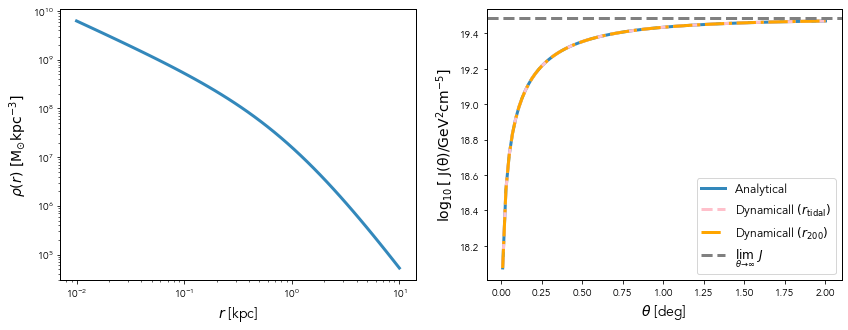

In [12]:
# plt.style.use('/users/Juan/phd/matplotlib/jdefault.mplstyle')
r = jnp.logspace(-2,1)
fig,ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].plot(r,halo.density(r))
ax[0].set(
    xscale= 'log',
    yscale= 'log',
    xlabel= r'$r$ [kpc]',
    ylabel= r'$\rho(r)~[\rm M_{\odot} kpc^{-3}]$',
);

ax[1].plot(((theta)*u.rad).to(u.deg).value,jnp.log10((J_analytic(theta,param_dict['rhos'],param_dict['rs'],d_dracoish,rt_dracoish)*u.solMass**2/u.kpc**5 *const.c**4).to(u.GeV**2/u.cm**5).value),
            label='Analytical')
ax[1].plot(((theta)*u.rad).to(u.deg).value,jvec3,linestyle='--',color='pink',label=r'Dynamicall $(r_{\rm tidal})$')
ax[1].plot(((theta)*u.rad).to(u.deg).value,jvec4,linestyle='-.',color='orange',label = r'Dynamicall $(r_{200})$')
ax[1].axhline(logJ_asymptotic,
            linestyle='--',
            color='gray',
            label=r'$\lim_{\theta\to\infty}~J$')
ax[1].set(
    xlabel= r'$\theta$ [deg]',
    ylabel= r'$\log_{10}\left[\rm~J(\theta)/\rm GeV^2 cm^{-5}\right]$',
    # xscale='log'
);
ax[1].legend();

Results between the two methods agree!

## Inference

If you need to do some sort of inference/MCMC then you'd want to instead use the "Internal functions" i.e. class methods.
The only diffrerence will be an _ at the beginning of the function name, and that it takes an additional parameter param_dict.
This function will work within a numpyro model.

In [13]:
from dynamicAll.models import HernquistZhao
J_factor = HernquistZhao._jFactor(theta0,param_dict, d_dracoish,rt_dracoish)

## Forecasting 
... coming soon 